In [1]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

C:\Users\AMOS\anaconda3\envs\Deeplearning\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Resize all the images to this
IMAGE_SIZE = [224, 224]
train_path = 'C:/Users/AMOS/Desktop/My Final Codes/CXR datasets/train'
test_path = 'C:/Users/AMOS/Desktop/My Final Codes/CXR datasets/test'
valid_path = 'C:/Users/AMOS/Desktop/My Final Codes/CXR datasets/val'

In [4]:
#Add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# Useful for getting the number of classes
folders = glob('CXR datasets/Train/*')

# Adding number of layers
x = Flatten()(vgg.output)
x = Dense(64, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

In [5]:
# Create a model object
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Fix the typo here
    metrics=['accuracy']
)

In [7]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_path,  # Remove quotes around train_path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    valid_path,  # Remove quotes around valid_path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
# Fit the model
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=5,
    validation_steps=3  # Fix the typo here
)

C:\Users\AMOS\AppData\Local\Temp\ipykernel_11256\1633043523.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
5/5 [==============================] - 72s 14s/step - loss: 3.6943 - accuracy: 0.6375 - val_loss: 2.8777 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 62s 12s/step - loss: 0.5427 - accuracy: 0.7312
Epoch 3/5
5/5 [==============================] - 61s 12s/step - loss: 0.3460 - accuracy: 0.8250
Epoch 4/5
5/5 [==============================] - 64s 12s/step - loss: 0.4079 - accuracy: 0.8375
Epoch 5/5
5/5 [==============================] - 64s 13s/step - loss: 0.2338 - accuracy: 0.8813


In [9]:
# Save the model to a file
model.save('Pneumonet.keras')

1/1 [==============================] - 7s 7s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.55      0.75      0.63         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16

Confusion Matrix:
 [[3 5]
 [2 6]]
ROC-AUC Score: 0.53125


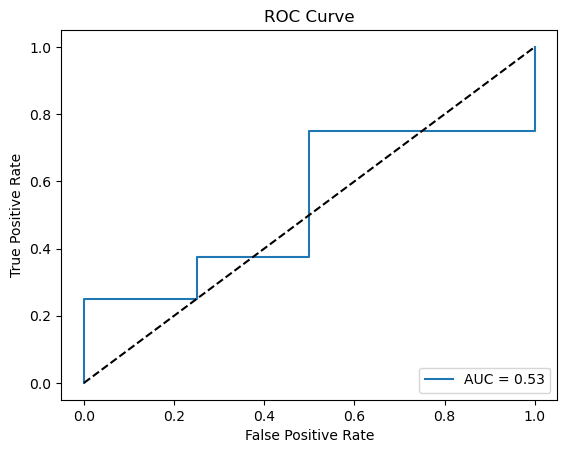

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# Evaluating the model on the test set
test_set.reset()  # Resetting the test set generator to the beginning
predictions = model.predict(test_set)

# Convert one-hot encoded labels back to class labels
y_true = test_set.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate and print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Calculating and printing confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_true, predictions[:, 1])
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()